# Reconnaissance faciale par SVM (et ACP) 

https://github.com/gouravaich/faces-recognition-pca/blob/master/PCA%20Mini-Project.ipynb

In [1]:
import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.externals import joblib # save and load models

# # save the model to disk
# filename = 'modeles/SVM'
# joblib.dump(SVM, filename)

# # load the model from disk
# loaded_model = joblib.load(filename)

/home/malick/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Loading the dataset

In [2]:
# On télécharge les données, si elles ne sont pas déjà sur le disque et on les charge sous forme de tableaux numpy.
path_home = '/home/malick/Bureau/Data/Statistique_en_grande_dimension/data'
lfw_people = fetch_lfw_people(path_home, min_faces_per_person=70, resize=0.4)

In [3]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)


# for machine learning we use the data directly (as relative pixel position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Information sur le dataset:")
print(" * nombre de lignes: %d" % n_samples)
print(" * nombre de variables: %d" % n_features)
print( " * nombre de classes: %d" % n_classes)

Information sur le dataset:
 * nombre de lignes: 1288
 * nombre de variables: 1850
 * nombre de classes: 7


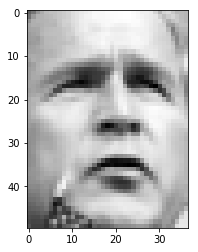

In [4]:
pl.imshow(X[2,:].reshape((h, w)), cmap=pl.cm.gray)

### Split into a training and testing set

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### ACP 

In [6]:
n_components = 100

# TODO: Create an instance of PCA, initializing with n_components=n_components and whiten=True
pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized')

#TODO: pass the training dataset (X_train) to pca's 'fit()' method
pca = pca.fit(X_train)

In [7]:
print("proportion de variance associée aux 10 premiéres axex:\n",pca.explained_variance_ratio_[:10])

proportion de variance associée aux 10 premiéres axex:
 [0.18945077 0.15410423 0.07173893 0.05956379 0.05092185 0.02902107
 0.02535695 0.02199671 0.02019029 0.01868446]


In [8]:
print("proportion total de variance associées aux axes: ",round(sum(pca.explained_variance_ratio_),4))

proportion total de variance associées aux axes:  0.9292


In [9]:
#Principal axes in feature space, representing the directions of maximum variance in the data.
#The components are sorted by explained_variance_.
eigenfaces = pca.components_.reshape((n_components, h, w))

#Apply dimensionality reduction to X.
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

### Train a SVM classification model 

##### a. SVM Linear 

In [10]:
# #on crée un nouveau modèle SVM à noyau Polynomiale
# svmLINEAR = SVC(kernel='linear',class_weight='balanced',probability=True)

# #on crée un dictionnaire de toutes les valeurs que nous voulons tester
# param_grid_LINEAR = {"C": [0.01,1,10,20,50,100,500,1000,10000]}

# #on utilise gridsearch pour tester toutes les valeurs
# svmLINEAR_gscv = GridSearchCV(svmLINEAR, param_grid_LINEAR, cv=5, n_jobs=-1, verbose=10)

# #ajustement du modèle aux données
# t_debut = time.time()
# svmLINEAR_gscv.fit(X_train_pca, y_train)
# t_fin = time.time()

# temps_SVM_Linear = (t_fin - t_debut)/60

# print("Précision Train: ",round(svmLINEAR_gscv.score(X_train_pca, y_train),3))
# print("Précision Test: ",round(svmLINEAR_gscv.score(X_test_pca, y_test),3))
# print("\n")
# print(svmLINEAR_gscv.best_params_)

In [11]:
# save the model to disk
filename = 'modeles/svmLINEAR_gscv'
#joblib.dump(svmLINEAR_gscv, filename)

# load the model from disk
svmLINEAR_gscv = joblib.load(filename)

In [12]:
print("Précision Train: ",round(svmLINEAR_gscv.score(X_train_pca, y_train),3))
print("Précision Test: ",round(svmLINEAR_gscv.score(X_test_pca, y_test),3))
print("\n")
print(svmLINEAR_gscv.best_params_)

Précision Train:  0.927
Précision Test:  0.788


{'C': 0.01}


In [13]:
y_pred_LINEAR = svmLINEAR_gscv.predict(X_test_pca)

#Sklearn's classification_report montre quelques-unes des principales mesures de classification pour chaque classe:
print(classification_report(y_test, y_pred_LINEAR, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.54      0.83      0.65        18
     Colin Powell       0.76      0.84      0.80        69
  Donald Rumsfeld       0.64      0.68      0.66        34
    George W Bush       0.93      0.80      0.86       166
Gerhard Schroeder       0.63      0.84      0.72        31
      Hugo Chavez       0.86      0.63      0.73        19
       Tony Blair       0.78      0.78      0.78        50

         accuracy                           0.79       387
        macro avg       0.73      0.77      0.74       387
     weighted avg       0.81      0.79      0.79       387



In [14]:
print(confusion_matrix(y_test, y_pred_LINEAR, labels=range(n_classes)))

[[ 15   0   3   0   0   0   0]
 [  3  58   1   3   1   1   2]
 [  4   2  23   2   2   0   1]
 [  4  10   7 132   6   1   6]
 [  1   1   0   1  26   0   2]
 [  1   3   0   1   2  12   0]
 [  0   2   2   3   4   0  39]]


#### b. SVM Poly

In [15]:
# #on crée un nouveau modèle SVM à noyau Polynomiale
# svmPOLY = SVC(kernel='poly',class_weight='balanced', probability=True)

# #on crée un dictionnaire de toutes les valeurs que nous voulons tester
# param_grid_POLY = {
#                    "C": [0.01,1,10,20,50,100,500,1000],
#                    "gamma" : np.arange(0,1.1,0.1),
#                    "degree": [2,3,4,6],
#                    "coef0": np.arange(0,1,0.5)
#                    }

# #on utilise gridsearch pour tester toutes les valeurs
# svmPOLY_gscv = GridSearchCV(svmPOLY, param_grid_POLY, cv=5, n_jobs=-1, verbose=10)

# #ajustement du modèle aux données
# t_debut = time.time()
# svmPOLY_gscv.fit(X_train_pca, y_train)
# t_fin = time.time()

# temps_SVM_Poly = (t_fin - t_debut)/60

# print("Précision Train: ",round(svmPOLY_gscv.score(X_train_pca, y_train),3))
# print("Précision Test: ",round(svmPOLY_gscv.score(X_test_pca, y_test),3))
# print("\n")
# print(svmPOLY_gscv.best_params_)

In [16]:
# save the model to disk
filename = 'modeles/svmPOLY_gscv'
#joblib.dump(svmPOLY_gscv, filename)

# load the model from disk
svmPOLY_gscv = joblib.load(filename)

In [17]:
print("Précision Train: ",round(svmPOLY_gscv.score(X_train_pca, y_train),3))
print("Précision Test: ",round(svmPOLY_gscv.score(X_test_pca, y_test),3))
print("\n")
print(svmPOLY_gscv.best_params_)

Précision Train:  1.0
Précision Test:  0.788


{'C': 1, 'coef0': 0.5, 'degree': 2, 'gamma': 0.1}


In [18]:
y_pred_POLY = svmPOLY_gscv.predict(X_test_pca)

#Sklearn's classification_report montre quelques-unes des principales mesures de classification pour chaque classe:
print(classification_report(y_test, y_pred_POLY, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.33      0.44        18
     Colin Powell       0.92      0.86      0.89        69
  Donald Rumsfeld       0.77      0.59      0.67        34
    George W Bush       0.73      0.96      0.83       166
Gerhard Schroeder       0.76      0.61      0.68        31
      Hugo Chavez       0.89      0.42      0.57        19
       Tony Blair       0.92      0.66      0.77        50

         accuracy                           0.79       387
        macro avg       0.81      0.63      0.69       387
     weighted avg       0.80      0.79      0.78       387



In [19]:
print(confusion_matrix(y_test, y_pred_POLY, labels=range(n_classes)))

[[  6   0   2  10   0   0   0]
 [  1  59   0   6   1   1   1]
 [  1   1  20  12   0   0   0]
 [  0   2   3 160   1   0   0]
 [  0   0   1  10  19   0   1]
 [  1   2   0   4   3   8   1]
 [  0   0   0  16   1   0  33]]


#### c. SMV Rbf

In [20]:
# #on crée un nouveau modèle SVM à noyau Gaussien
# svmRBF = SVC(kernel='rbf',class_weight='balanced',probability=True)

# #on crée un dictionnaire de toutes les valeurs que nous voulons tester
# param_grid_RBF = {
#                   "C": [0.01,1,10,20,50,100,500,1000,10000],
#                   "gamma" : np.arange(0,1,0.05)
#                  }

# #on utilise gridsearch pour tester toutes les valeurs de param_grid
# svmRBF_gscv = GridSearchCV(svmRBF, param_grid_RBF, cv=5, n_jobs=-1, verbose=10)

# #ajustement du modèle aux données
# t_debut = time.time()
# svmRBF_gscv.fit(X_train_pca,y_train)
# t_fin = time.time()

# temps_SVM_Rbf = (t_fin - t_debut)/60

# print("Précision Train: ",round(svmRBF_gscv.score(X_train_pca,y_train),3))
# print("Précision Test: ",round(svmRBF_gscv.score(X_test_pca,y_test),3))
# print("\n")

# print(svmRBF_gscv.best_params_)

In [21]:
# save the model to disk
filename = 'modeles/svmRBF_gscv'
#joblib.dump(svmRBF_gscv, filename)

# load the model from disk
svmRBF_gscv = joblib.load(filename)

In [22]:
print("Précision Train: ",round(svmRBF_gscv.score(X_train_pca,y_train),3))
print("Précision Test: ",round(svmRBF_gscv.score(X_test_pca,y_test),3))
print("\n")

print(svmRBF_gscv.best_params_)

Précision Train:  1.0
Précision Test:  0.465


{'C': 1, 'gamma': 0.05}


In [23]:
y_pred_RBF = svmRBF_gscv.predict(X_test_pca)

#Sklearn's classification_report montre quelques-unes des principales mesures de classification pour chaque classe:
print(classification_report(y_test, y_pred_RBF, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        18
     Colin Powell       1.00      0.19      0.32        69
  Donald Rumsfeld       1.00      0.03      0.06        34
    George W Bush       0.45      1.00      0.62       166
Gerhard Schroeder       0.00      0.00      0.00        31
      Hugo Chavez       0.00      0.00      0.00        19
       Tony Blair       0.00      0.00      0.00        50

         accuracy                           0.47       387
        macro avg       0.35      0.17      0.14       387
     weighted avg       0.46      0.47      0.33       387



/home/malick/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
print(confusion_matrix(y_test, y_pred_RBF, labels=range(n_classes)))

[[  0   0   0  18   0   0   0]
 [  0  13   0  56   0   0   0]
 [  0   0   1  33   0   0   0]
 [  0   0   0 166   0   0   0]
 [  0   0   0  31   0   0   0]
 [  0   0   0  19   0   0   0]
 [  0   0   0  50   0   0   0]]


#### c. KNN

In [25]:
# #on crée un nouveau modèle knn2
# knn = KNeighborsClassifier()

# max_Voisins = 101

# #on crée un dictionnaire de toutes les valeurs que nous voulons tester avec n_neighbors
# param_grid_KNN = {"n_neighbors": np.arange(1, max_Voisins), "weights" : ["uniform", "distance"]}

# #on utilise gridsearch pour tester toutes les valeurs de n_neighbors
# knn_gscv = GridSearchCV(knn, param_grid_KNN, cv=5, n_jobs=-1, verbose=10)

# #ajustement du modèle aux données
# t_debut = time.time()
# knn_gscv.fit(X_train_pca,y_train)
# t_fin = time.time()

# temps_SVM_knn = (t_fin - t_debut)/60

# print("Précision Train: ",round(knn_gscv.score(X_train_pca,y_train),3))
# print("Précision Test: ",round(knn_gscv.score(X_test_pca,y_test),3))
# print("\n")

# print(knn_gscv.best_params_)

In [26]:
# save the model to disk
filename = 'modeles/knn_gscv'
#joblib.dump(knn_gscv, filename)

# load the model from disk
knn_gscv = joblib.load(filename)

In [27]:
print("Précision Train: ",round(knn_gscv.score(X_train_pca,y_train),3))
print("Précision Test: ",round(knn_gscv.score(X_test_pca,y_test),3))
print("\n")

print(knn_gscv.best_params_)

Précision Train:  1.0
Précision Test:  0.693


{'n_neighbors': 4, 'weights': 'distance'}


In [28]:
y_pred_KNN = knn_gscv.predict(X_test_pca)

#Sklearn's classification_report montre quelques-unes des principales mesures de classification pour chaque classe:
print(classification_report(y_test, y_pred_KNN, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.28      0.36        18
     Colin Powell       0.88      0.67      0.76        69
  Donald Rumsfeld       0.53      0.50      0.52        34
    George W Bush       0.68      0.95      0.79       166
Gerhard Schroeder       0.63      0.39      0.48        31
      Hugo Chavez       0.89      0.42      0.57        19
       Tony Blair       0.69      0.44      0.54        50

         accuracy                           0.69       387
        macro avg       0.69      0.52      0.57       387
     weighted avg       0.70      0.69      0.67       387



In [29]:
print(confusion_matrix(y_test, y_pred_KNN, labels=range(n_classes)))

[[  5   0   2   8   1   1   1]
 [  2  46   3  15   1   0   2]
 [  1   0  17  14   1   0   1]
 [  0   1   4 158   1   0   2]
 [  1   1   2  11  12   0   4]
 [  1   1   1   6   2   8   0]
 [  0   3   3  21   1   0  22]]


#### d. LogisticRegression

#### e. Combinaison de modéles

In [30]:
Estimateurs = [('linear', svmLINEAR_gscv.best_estimator_), # a.
               ('poly', svmPOLY_gscv.best_estimator_), # b.
               ('rbf', svmRBF_gscv.best_estimator_) # c.
              ]

poids = [svmLINEAR_gscv.score(X_test_pca, y_test),
         svmPOLY_gscv.score(X_test_pca, y_test),
         svmRBF_gscv.score(X_test_pca, y_test)
        ]

SVM = VotingClassifier(estimators=Estimateurs, 
                       voting='soft',
                       weights=poids,
                       n_jobs=-1)

In [31]:
SVM.fit(X_train_pca, y_train)

VotingClassifier(estimators=[('linear',
                              SVC(C=0.01, cache_size=200,
                                  class_weight='balanced', coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='auto_deprecated', kernel='linear',
                                  max_iter=-1, probability=True,
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False)),
                             ('poly',
                              SVC(C=1, cache_size=200, class_weight='balanced',
                                  coef0=0.5, decision_function_s...
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False)),
                             ('rbf',
                              SVC(C=1, cache_size=200, class_weight='balanced',
                                  coef0=0.0, decisi

In [32]:
# save the model to disk
filename = 'modeles/SVM'
#joblib.dump(SVM, filename)

# load the model from disk
SVM = joblib.load(filename)

In [33]:
print("Précision Train: ",round(SVM.score(X_train_pca,y_train),3))
print("Précision Test: ",round(SVM.score(X_test_pca,y_test),3))

Précision Train:  1.0
Précision Test:  0.835


In [34]:
y_pred_SVM = SVM.predict(X_test_pca)

#Sklearn's classification_report montre quelques-unes des principales mesures de classification pour chaque classe:
print(classification_report(y_test, y_pred_SVM, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.72      0.76        18
     Colin Powell       0.88      0.87      0.88        69
  Donald Rumsfeld       0.73      0.65      0.69        34
    George W Bush       0.83      0.94      0.88       166
Gerhard Schroeder       0.83      0.77      0.80        31
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.84      0.72      0.77        50

         accuracy                           0.83       387
        macro avg       0.84      0.76      0.79       387
     weighted avg       0.84      0.83      0.83       387



In [35]:
print(confusion_matrix(y_test, y_pred_SVM, labels=range(n_classes)))

[[ 13   0   3   2   0   0   0]
 [  1  60   0   4   1   1   2]
 [  1   2  22   9   0   0   0]
 [  0   3   5 156   1   0   1]
 [  0   0   0   3  24   0   4]
 [  1   3   0   2   1  12   0]
 [  0   0   0  12   2   0  36]]
